In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
import openpyxl
from afinn import *



path_src = 'D:/Reepo_Git/Google_play_store/src'
sys.path.append(path_src)

from data_analyser import *
from data_cleaner import *
from data_exploration import *
from data_ingestor import *
from data_visualizer import *
from database_handler import *

# Caricamento delle  le variabili d'ambiente dal file config.json
config_path = 'D:/Reepo_Git/Google_play_store/'
with open(config_path + 'config.json', 'r') as file:
    config = json.load(file)


raw_data_path = config['raw_data_path']
clean_data_path = config['clean_data_path']
merged_data_path = config['merged_data_path']
db_connection_string = config['db_connection_string']
positive_words_path = config['positive_words_path']
negative_words_path = config["negative_words_path"]
images_path = config['images_path']
schema = config['schema']


In [8]:
def automate_processor(file):
    """
    Funzione per automatizzare la pulizia e la preparazione dei dati.
    
    Args:
    - file (str): il percorso del file da elaborare.
    
    Returns:
    - DataFrame: dataframe elaborato.
    """
    
    # Carica i dati
    # Definisce l'istanza input data come appartenente alla classe DataIngressor
    input_data = DataIngressor()
    
    # Applica il metodo load file che ci restituirà il file come attributo data
    input_data.load_file(file)

    # Inizializza l'oggetto DataProcessor e carica i dati.
    processor = DataProcessor(input_data.data)

    # Fase di pulizia e preparazione dei dati
    # Inizializza l'oggetto DataProcessor e carica i dati.
    processor = DataProcessor(input_data.data)

    # Pulisci i dati: rimuovi caratteri speciali, valori nulli e converte colonne.
    processor.clean_function()

    # Converte le unità 'M' e 'k' nella colonna 'Size'.
    processor.converter(series='Size', item1='M', item2='k', operation1={'pro': 1}, operation2={'div': 1024})

    # Sostituisci 'Varies with device' con NaN nella colonna 'Size'.
    processor.substitute(item=['Varies with device'], item_sub=[np.nan], scope='some', series=['Size'])

    # Converte la colonna 'Size' in float.
    processor.casting(series=['Size'], tipe=['float'])

    # Imputa i valori mancanti nelle colonne 'Size' e 'Rating'.
    processor.imputator(series=['Size', 'Rating'], value=['mode', 'mean'])

    # Pulisce la colonna 'Genres', rimuovendo '&' e ';'.
    processor.substitute(item=['&', ';'], item_sub=['', ''], scope='some', series=['Genres'])

    # Ordina i dati in base alle 'Reviews' e rimuove i duplicati.
    processor.sort_data(column_order=['Reviews'])

    # Elimina una riga specifica (riga 10472).
    processor.dropper_axis(item=10472, axis=0)

    # Converte la colonna 'Last Updated' in formato datetime.
    processor.casting(series=['Last Updated'], tipe=['date'])
    
    # Salva il dataframe modificato nella cartella 'cleaned'
    input_data.save_file(clean_data_path + 'clean_googleplaystore.csv', format='csv')
    
    print('cleaning completed')
    return processor.data




#################################################################
def exploration(db2, col2):
    """
    Funzione per esplorare la distribuzione di alcune colonne del dataframe.
    
    Args:
    - db2 (DataFrame): dataframe da esplorare.
    - col2 (list): lista di colonne da esplorare.
    """
    
    data = DataExploration(db2)
    data.distribution(columns= col2, save_path_prefix= images_path)
    
    print('Exploration completed')




#####################################################
# Preparazione del db google play store user rewiev per la sentiment analysis
def preparation_db_rewiev(path= raw_data_path, file_rev_name= 'googleplaystore_user_reviews.csv'):
    # Carica il Dataframe e pulisce i dati
    db_rev = DataIngressor()
    db_rev.load_file(path + file_rev_name)
    db_rev_mod = db_rev.series_view(["App", "Translated_Review"]).drop_duplicates().dropna()

    # Salva il Dataframe pulito in un file csv 
    db_rev_mod.to_csv(clean_data_path + 'clean_' + file_rev_name)
    
    print('preparation_db_rewiev completed')
    return db_rev_mod



    
###################################################################  
def analyser(dbreview):
    """
    Funzione per la sentiment analysis delle recensioni.
    
    Args:
    - db2 (DataFrame): dataframe originale.
    - dbreview (str): percorso del file delle recensioni.
    
    Returns:
    - DataFrame: dataframe con la sentiment analysis.
    """
    test = DataAnalyser(db_rev_mod)
    test.building_afinn()
    test.add_word(positive_words_path, negative_words_path)
    test.sentiment_score()
    sentiment_analysis_db = test.sentiment_update()

    # Creazione del database contenente gli score della sentiment analysis
    sentiment_analysis_db.to_csv(clean_data_path + 'sentiment_analysis_db.csv')
    
    print('Analyses completed')
    return sentiment_analysis_db
    
    


###################################################################
def visualizer(sentiment_analysis_db):
    """
    Funzione per visualizzare i dati.
    
    Args:
    - path (str): percorso del file da visualizzare.
    """
    dataviz = DataVisualizer(sentiment_analysis_db)
    dataviz.barplot(xb="scoresentiment_y", yb="App", save_path= images_path)
    print('Viewing and saving completed')
    #dataviz.correlation()


    
    
####################################################################
# Crea la connessione e popola il database con i dati 
def connection(conn_string, clean_data_path, schema, table_name):
    try:
        original_data = pd.read_csv(clean_data_path)
        conn_handler = SQLHandler(original_data, conn_string, schema)
        conn_handler.load_original_data(table_name)
        conn_handler.close_connection()
        
        print('Connection completed')
    
    except Exception as error:
        print(f"Error in connection function: {error}")

In [9]:
# Fase di pulizia e preparazione dei dati
file = raw_data_path + "googleplaystore.csv"
db2 = automate_processor(file)
print(db2.head(5))

cleaning completed
                           App          Category    Rating  Reviews  Size  \
6888            BV Productions          BUSINESS  4.189542      0.0  28.0   
7225  CE Genius Nurses Edition           MEDICAL  4.189542      0.0  51.0   
7224                  Ceasa CE             TOOLS  4.189542      0.0  40.0   
7221           CESETRAM lAppli  LIBRARIESANDDEMO  4.189542      0.0  26.0   
7217                  CESTRONG            FAMILY  4.189542      0.0  16.0   

      Installs  Type  Price Content Rating           Genres Last Updated  \
6888       1.0  Free    0.0       Everyone         Business   2016-10-25   
7225       1.0  Paid  399.0       Everyone          Medical   2018-06-01   
7224      50.0  Free    0.0       Everyone            Tools   2018-06-13   
7221     100.0  Free    0.0       Everyone  Libraries  Demo   2017-12-05   
7217     100.0  Free    0.0       Everyone        Education   2016-06-17   

     Current Ver Android Ver  
6888         101   40 and up  

count      10357
unique        33
top       FAMILY
freq        1943
Name: Category, dtype: object


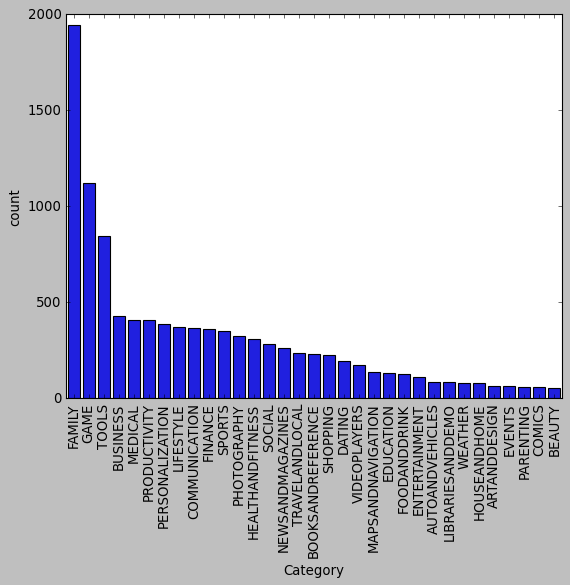

count    10357.000000
mean         4.188112
std          0.484020
min          1.000000
25%          4.100000
50%          4.200000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64


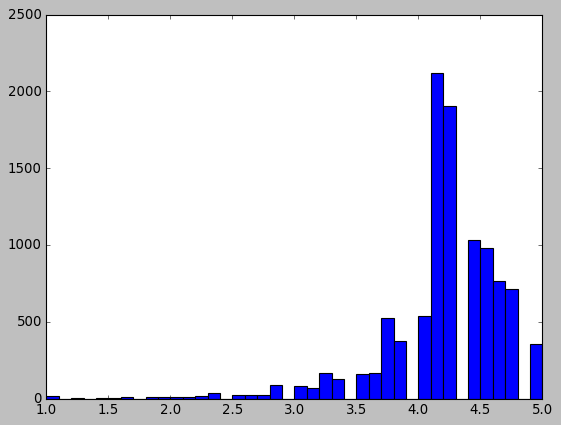

Exploration completed


In [10]:
# Fase di esplorazione dei dati
exploration(db2, ["Category", "Rating"])

In [11]:
# Fase di preparazione delle rewiev
db_rev_mod = preparation_db_rewiev(path= raw_data_path, file_rev_name= 'googleplaystore_user_reviews.csv')

preparation_db_rewiev completed


In [12]:
# Fase di analisi dei sentimenti delle recensioni
db_rev_sentiment = analyser(db_rev_mod)

Analyses completed


D:\Reepo_Git/Google_play_store/src\data_visualizer.py:34: UserWarning: Glyph 28961 (\N{CJK UNIFIED IDEOGRAPH-7121}) missing from current font.
  plt.savefig(save_path + f'correlation_between_{xb}_and_{yb}.png')
D:\Reepo_Git/Google_play_store/src\data_visualizer.py:34: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from current font.
  plt.savefig(save_path + f'correlation_between_{xb}_and_{yb}.png')
D:\Reepo_Git/Google_play_store/src\data_visualizer.py:34: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from current font.
  plt.savefig(save_path + f'correlation_between_{xb}_and_{yb}.png')
D:\Reepo_Git/Google_play_store/src\data_visualizer.py:34: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  plt.savefig(save_path + f'correlation_between_{xb}_and_{yb}.png')
D:\Reepo_Git/Google_play_store/src\data_visualizer.py:34: UserWarning: Glyph 12500 (\N{KATAKANA LETTER PI}) missing from current font.
  plt.savefig(save_path + f'correlati

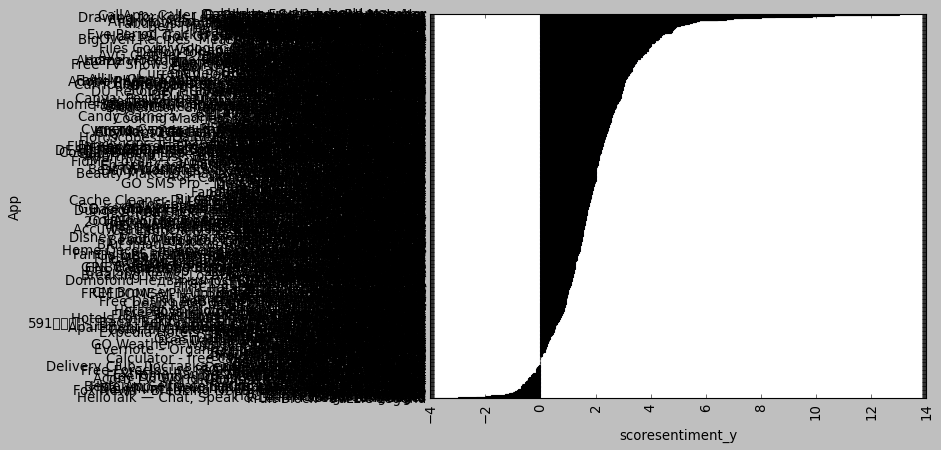

Viewing and saving completed


In [13]:
# Fase di visualizzazione dei dati
visualizer(db_rev_sentiment)

In [14]:
# Fase di caricamento dei dati nel database
google_data_name = clean_data_path + "clean_googleplaystore.csv"
google_data_review_name = clean_data_path + "clean_googleplaystore_user_reviews.csv"


In [15]:
# File clean_googleplaystore     
connection(conn_string= db_connection_string, 
            clean_data_path= google_data_name,  
            schema= schema,
            table_name= 'googleplaystore')

Connection completed


In [16]:
# File clean_googleplaystore_user_reviews
connection(conn_string= db_connection_string, 
            clean_data_path= google_data_review_name,  
            schema= schema,
            table_name= 'googleplaystore_user_reviews')


Connection completed
